<a href="https://colab.research.google.com/github/SuperYoungCoder/Machine-Learning-with-Python-Tensorflow/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.8.2
[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]
First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


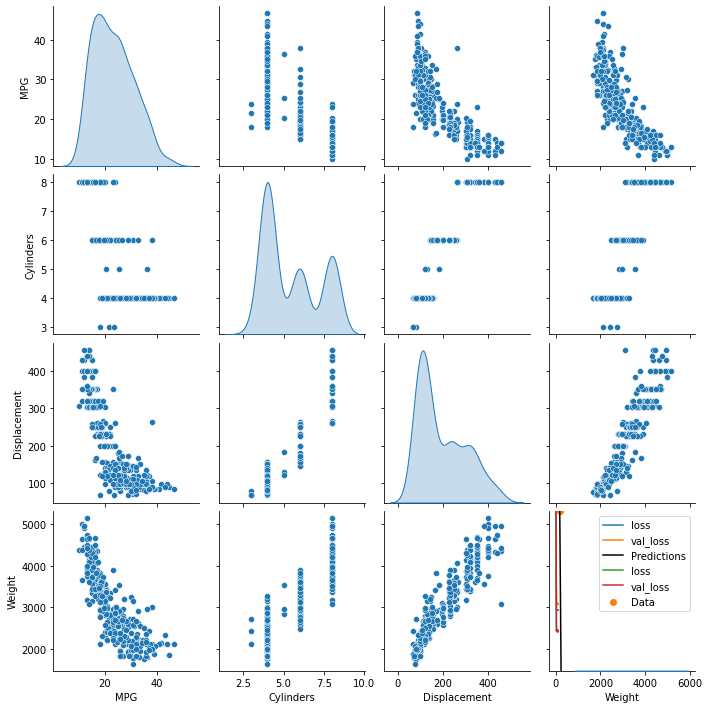

In [19]:
# This code uses the Keras API

# Use seaborn for pairplot.
!pip install -q seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# The Auto MPG dataset - get the data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

# Clean the data: the dataset contains a few unknown values
dataset.isna().sum()

# Note 1: Drop those rows to keep this initial project simple:
dataset = dataset.dropna()

# Note 2: The "Origin" column is categorical. So the next step is to one-hot encode the values in the column with pd.get_dummies.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

# Split the data into training and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#Inspect the data
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']], diag_kind='kde')

# Note 3: Overall statistics show each feature covers a very different range:
train_dataset.describe().transpose()

# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalization
train_dataset.describe().transpose()[['mean', 'std']]

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

# Linear regression with one variable
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
horsepower_model = tf.keras.Sequential([
                                        horsepower_normalizer,
                                        layers.Dense(units=1)
])
horsepower_model.summary()
# Note 4: this model will predict 'MPG' from 'Horsepower'.
horsepower_model.predict(horsepower[:10])
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)
test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()
plot_horsepower(x, y)

# Linear regression with multiple inputs
linear_model = tf.keras.Sequential([
                                    normalizer,
                                    layers.Dense(units=1)
])
linear_model.predict(train_features[:10])
linear_model.layers[1].kernel
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)
%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # suppress logging.
    verbose=0,
    # Caculate validation results on 20% of the training data.
    validation_split= 0.2
)
plot_loss(history)
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

# Regression with a deep neural network
